# Loan Approval Prediction

This notebook analyses the Loan Approval Prediction data

- https://www.kaggle.com/competitions/playground-series-s4e10/data

### Steps:
- Step 1: Load Data

### Models

xx

### Results

xx

# Step 0: Imports

In [123]:
#--------------------
# General
import pandas as pd
import numpy as np
import copy
pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 10000)
pd.options.display.float_format = '{:,.2f}'.format
#--------------------

#--------------------
# Seaborn
import seaborn as sns
import matplotlib.pyplot as plt
#--------------------

#--------------------
# Models
# XGBoost
from xgboost import XGBClassifier

# LightGBM
from lightgbm import LGBMClassifier
#--------------------

#--------------------
# SHAP Explainability
import shap
shap.initjs()
#--------------------

#--------------------
# Model Performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
#--------------------

#--------------------
# Gini by split
def gini_group(y_true=None, y_score=None, group=None, round=2):
    """
    Calculate Gini for each group
    """
    levels=group.unique()
    values=[]
    for this_level in levels:
        this_y_true=y_true[group==this_level]
        this_y_score=y_score[group==this_level]
        values.append(roc_auc_score(y_true=this_y_true, y_score=this_y_score)*2-1)
    return pd.DataFrame({'group':levels, 'Gini':values}).round(round)
#--------------------

#--------------------
# ROC Curve
def roc_curve_group(y_true=None, y_score=None, group=None, round=2):
    """
    Calculate ROC Curve for each group
    """
    levels=group.unique()
    prep_auc=pd.DataFrame()
    for this_level in levels:
        this_y_true=y_true[group==this_level]
        this_y_score=y_score[group==this_level]
        fpr, tpr, _= roc_curve(y_true=this_y_true, y_score=this_y_score)
        t1=pd.DataFrame({'Model': this_level, 'fpr': fpr, 'tpr': tpr})
        prep_auc=pd.concat([prep_auc, t1], axis=0)
    return prep_auc.round(round)
#--------------------

# Step 1: Load Data

In [118]:
# Load Data
loc='C:/Users/markt/My Drive/99 ML/17 Kaggle/04 Insurance Customer Data/'
df=pd.read_csv(f"{loc}train.csv") #\.drop(columns=['Unnamed: 0', 'id'])

# Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

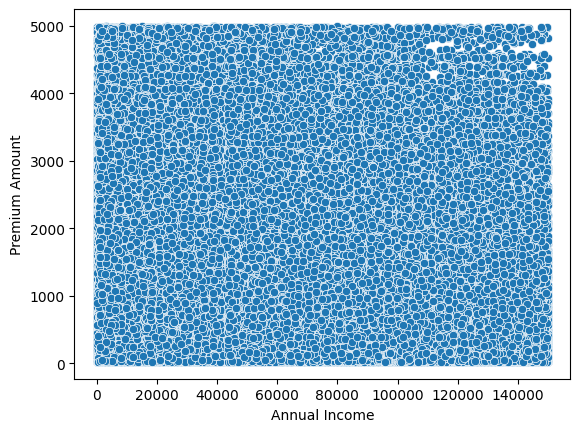

In [119]:
sns.scatterplot(df, x='Annual Income', y='Premium Amount')
plt.show()

In [122]:
df[['Premium Amount','Credit Score']].corr()

,Premium Amount,Credit Score
Premium Amount,1.00,-0.03
Credit Score,-0.03,1.00


# Step 2: Missing Data

Make these imputations:

| **Feature**           | **Imputation Method** |
|------------------------|-----------------------|
| Age                   | Mean Impute           |
| Annual Income         | Mean Impute           |
| Marital Status        | Unknown               |
| Number of Dependents  | 0                     |
| Occupation            | Unknown               |
| Health Score          | Mean Impute           |
| Previous Claims       | 0                     |
| Vehicle Age           | Mean Impute           |
| Credit Score          | Mean Impute           |
| Insurance Duration    | 0                     |
| Customer Feedback     | Unknown               |


In [107]:
# Percent missing for each feature
missingess_df=(df.isna().sum() / df.shape[0])\
    .reset_index()\
    .rename(columns={'index': 'Feature', 0: 'Pct'})

# Features with any missingness
missingess_df[missingess_df['Pct']>0]

,Feature,Pct
0,Age,0.02
2,Annual Income,0.04
3,Marital Status,0.02
4,Number of Dependents,0.09
6,Occupation,0.30
7,Health Score,0.06
10,Previous Claims,0.30
11,Vehicle Age,0.00
12,Credit Score,0.11
13,Insurance Duration,0.00


In [108]:
# Copy
df2=copy.deepcopy(df)

# Specific Imputations
def my_impute(impute_feature, impute_level):
    df2[impute_feature]=np.where(df2[impute_feature].isna(), 
                                 impute_level, 
                                 df2[impute_feature])
my_impute(impute_feature='Marital Status',       impute_level='Unknown')
my_impute(impute_feature='Number of Dependents', impute_level=0)
my_impute(impute_feature='Occupation',           impute_level='Unknown')
my_impute(impute_feature='Previous Claims',      impute_level=0)
my_impute(impute_feature='Insurance Duration',   impute_level=0)
my_impute(impute_feature='Customer Feedback',    impute_level='Unknown')

# Mean Imputations
def my_mean_impute(impute_feature):
    df2[impute_feature]=np.where(df2[impute_feature].isna(), 
                        df2[impute_feature].mean(), 
                        df2[impute_feature])
my_mean_impute('Age')
my_mean_impute('Annual Income')
my_mean_impute('Health Score')
my_mean_impute('Vehicle Age')
my_mean_impute('Credit Score')

# Remove spaces in feature names
df2.columns=df2.columns.str.replace(' ', '_')

# Information
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Age                   1200000 non-null  float64
 1   Gender                1200000 non-null  object 
 2   Annual_Income         1200000 non-null  float64
 3   Marital_Status        1200000 non-null  object 
 4   Number_of_Dependents  1200000 non-null  float64
 5   Education_Level       1200000 non-null  object 
 6   Occupation            1200000 non-null  object 
 7   Health_Score          1200000 non-null  float64
 8   Location              1200000 non-null  object 
 9   Policy_Type           1200000 non-null  object 
 10  Previous_Claims       1200000 non-null  float64
 11  Vehicle_Age           1200000 non-null  float64
 12  Credit_Score          1200000 non-null  float64
 13  Insurance_Duration    1200000 non-null  float64
 14  Policy_Start_Date     1200000 non-

# Step 3: Plot Data

### Response

### Numerical Features 

### Categorical Featues 

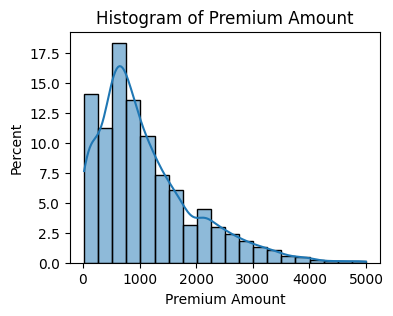

In [109]:
# Histogram of Premium_Amount
plt.figure(figsize=(4, 3))
sns.histplot(df2, 
             x='Premium_Amount', 
             bins=20, 
             stat='percent',
             kde=True,
             kde_kws={'bw_adjust': 3})
plt.title('Histogram of Premium Amount', loc='center')
plt.xlabel('Premium Amount')
plt.ylabel('Percent')
plt.show()

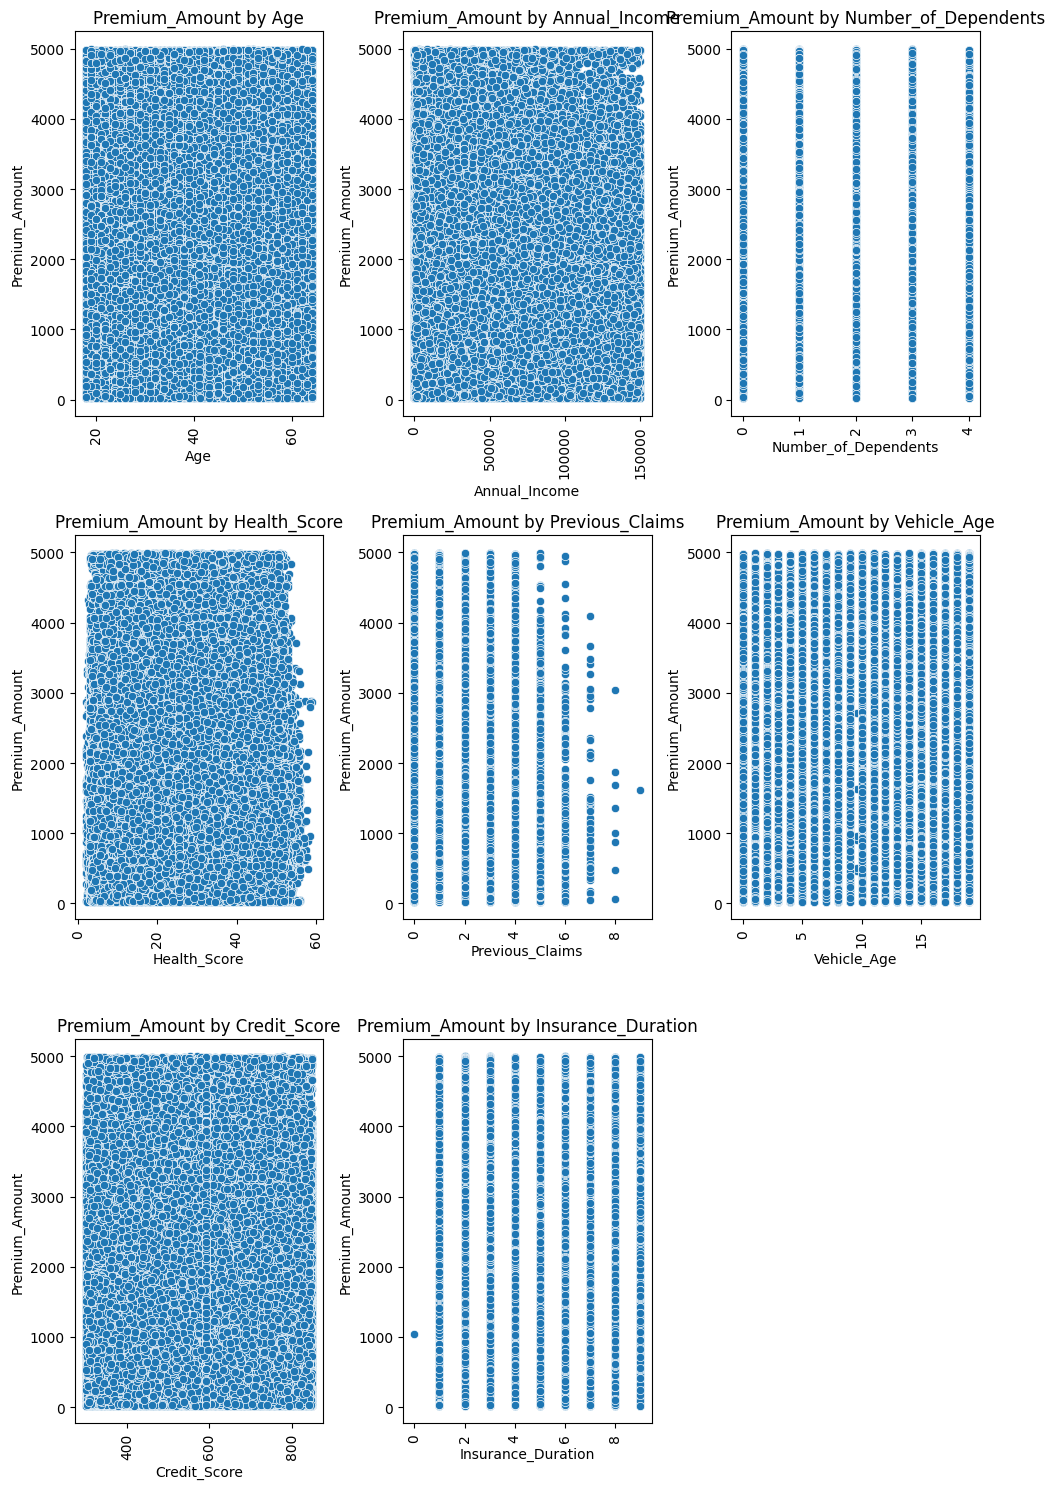

In [112]:
#============================================
# Plot Numeric Features

# Numeric Features
numeric_cols = df2.select_dtypes(include=[np.number]).columns.drop('Premium_Amount')
num_numeric_cols=len(numeric_cols)

# Set up grid dimensions
cols = 3
rows = (num_numeric_cols + cols - 1) // cols  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Loop over categorical columns
for i, col in enumerate(numeric_cols):
    ax = axes[i]  # Get the current axis
    sns.scatterplot(data=df2, x=col, y='Premium_Amount', ax=ax)
    ax.set_xlabel(col)
    ax.set_ylabel('Premium_Amount')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title(f'Premium_Amount by {col}')


# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()
#============================================

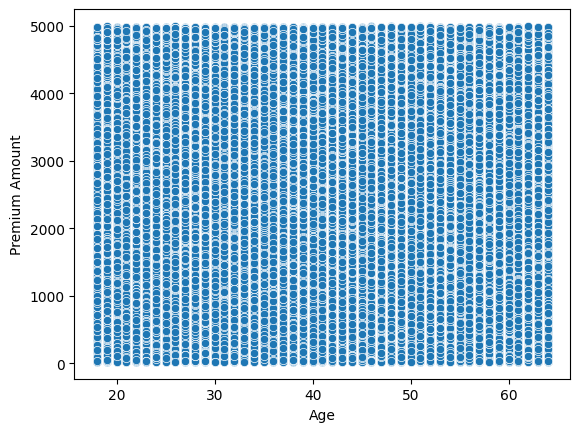

In [115]:
sns.scatterplot(df, x='Age', y='Premium Amount')
plt.show()

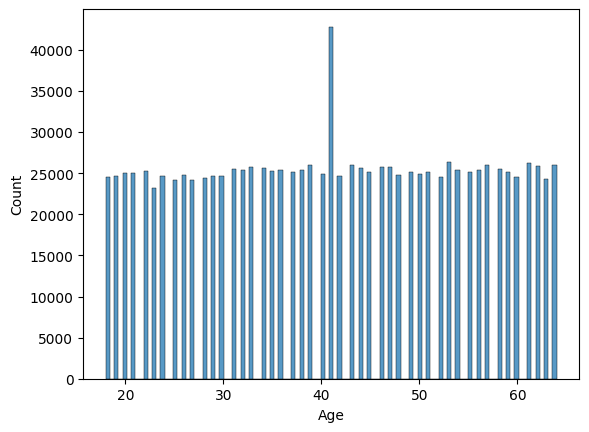

In [116]:
sns.histplot(df2, x='Age')
plt.show()


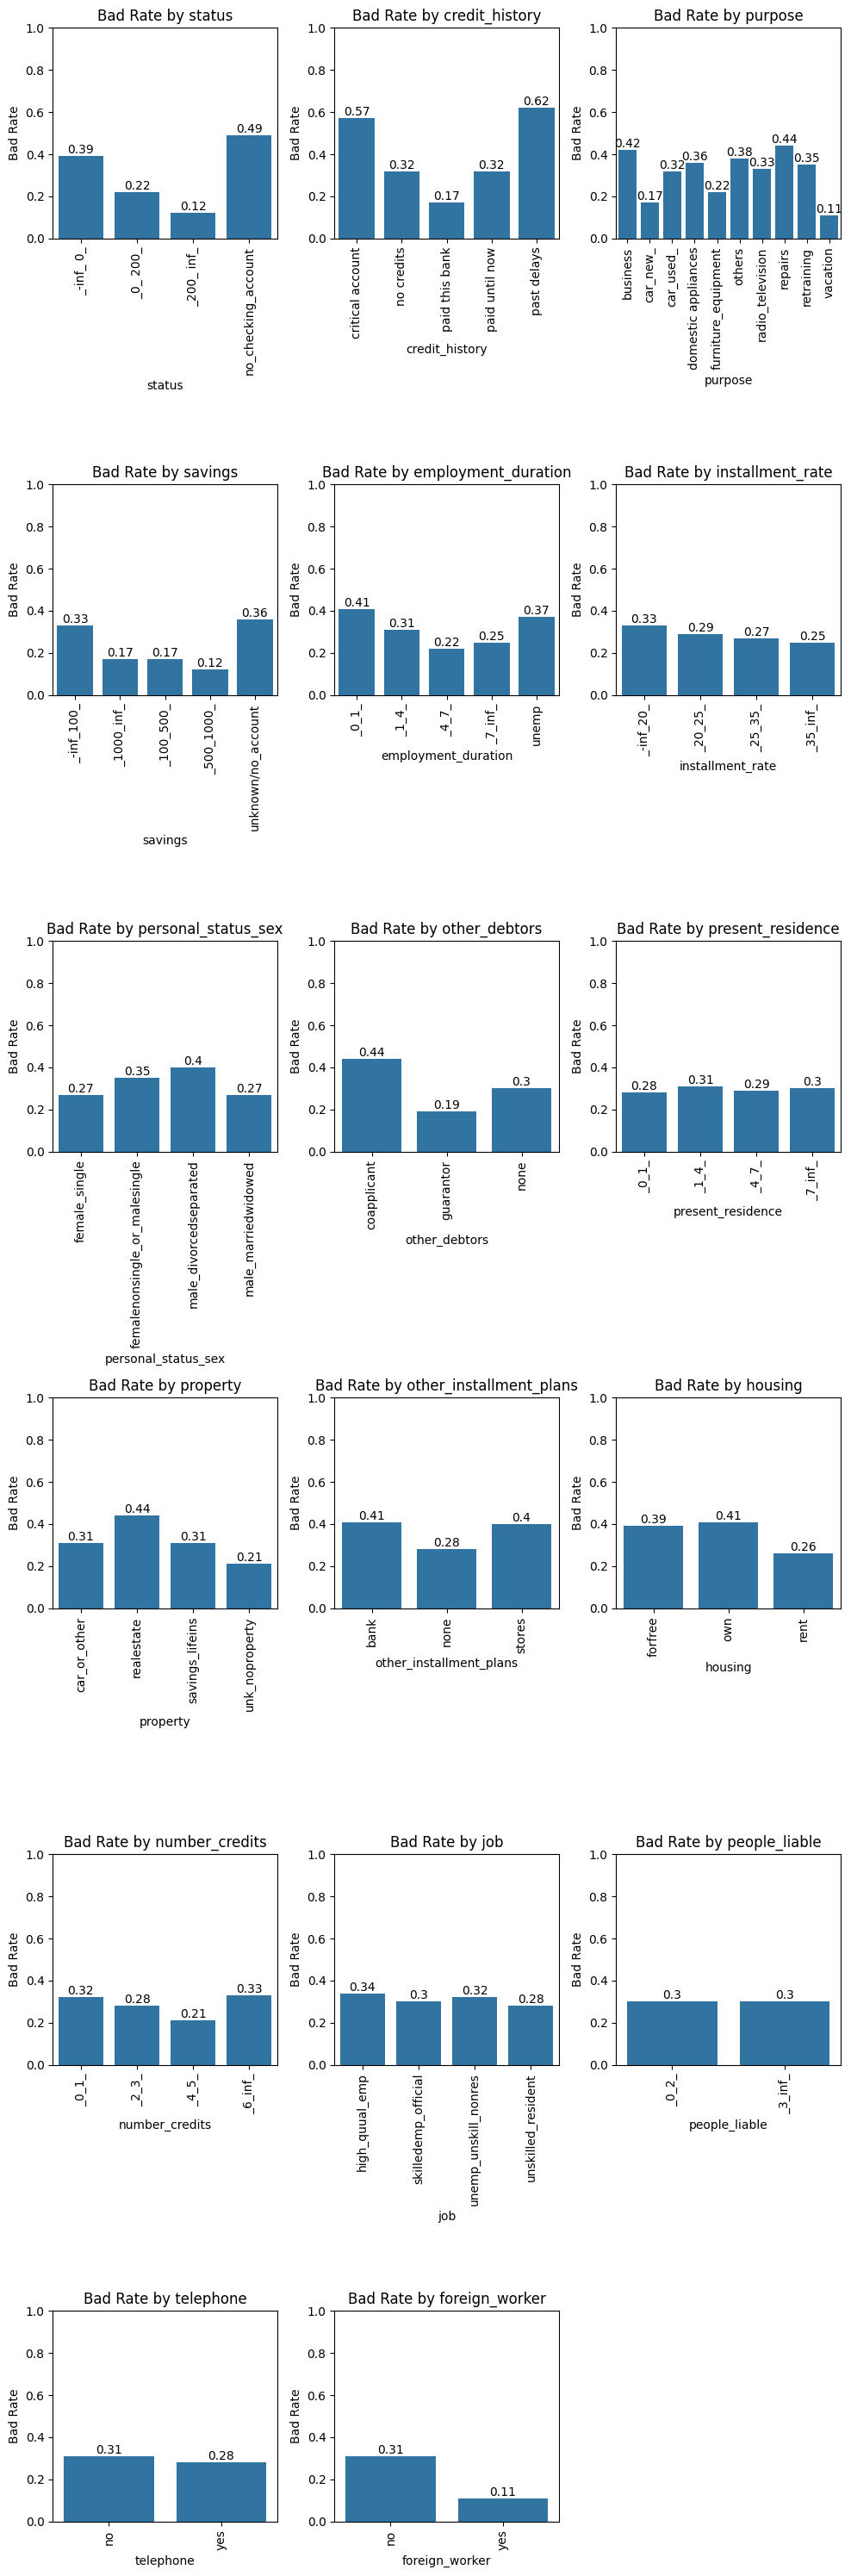

In [110]:
#============================================
# Plot Categorical Features

# Identify categorical columns
categorical_cols = df.select_dtypes(exclude=[np.number]).columns
num_categorical_cols = len(categorical_cols)

# Set up grid dimensions
cols = 3
rows = (num_categorical_cols + cols - 1) // cols  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Loop over categorical columns
for i, col in enumerate(categorical_cols):
    df_smry = df[['bad_flag', col]].groupby(col).mean().reset_index().round(2)

    ax = axes[i]  # Get the current axis
    sns.barplot(data=df_smry, x=col, y='bad_flag', ax=ax)
    ax.bar_label(ax.containers[0])
    ax.set_xlabel(col)
    ax.set_ylabel('Bad Rate')
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylim(0, 1)
    ax.set_title(f'Bad Rate by {col}')


# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()
#============================================

# Step 4: Prepare for Modelling

Undertake the following:

- one-hot dummy encoding of categorical featuers
- train-test split

In [111]:
# One-Hot Encoding
df2=copy.deepcopy(pd.get_dummies(df,dtype=int))
df2.columns=df2.columns.str.replace('-', '_').str.replace(' ', '_')

# X and y
X=df2.drop(['bad_flag'], axis=1)
y=df2['bad_flag']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Modeling

- XGBoost
- LightGBM
- CatBoost
- Random Forest
- Logistic Regression
- Naive Bayes
- K-Nearest Neighbours
- Support Vector Machine
- Neural Network (Multilayer Perceptron)
- Linear Discriminant Analysis

In [112]:
#--------------------
# XGBoost
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)
pred_xgb=pd.DataFrame({'model': 'xgb', 'target': y_test, 'pred': model_xgb.predict_proba(X_test)[:,1]})
#--------------------

In [113]:
#--------------------
# Light GBM
model_lgb=LGBMClassifier(verbose=-1)
model_lgb.fit(X_train, y_train)
pred_lgb=pd.DataFrame({'model': 'lgb', 'target': y_test, 'pred': model_lgb.predict_proba(X_test)[:,1]})
#--------------------

In [114]:
#--------------------
# Catboost
model_cat=CatBoostClassifier(verbose=False)
model_cat.fit(X_train, y_train)
pred_cat=pd.DataFrame({'model': 'cat', 'target': y_test, 'pred': model_cat.predict_proba(X_test)[:,1]})
#--------------------

In [115]:
#--------------------
# Random Forrest
model_rfc=RandomForestClassifier()
model_rfc.fit(X_train, y_train)
pred_rfc=pd.DataFrame({'model': 'rf', 'target': y_test, 'pred': model_rfc.predict_proba(X_test)[:,1]})
#--------------------

In [116]:
#--------------------
# Logistic Regression
model_lrg=LogisticRegression(penalty=None, solver='newton-cg')
model_lrg.fit(X_train, y_train)
pred_lrg=pd.DataFrame({'model': 'lr', 'target': y_test, 'pred': model_lrg.predict_proba(X_test)[:,1]})
#--------------------

In [117]:
#--------------------
# Naive Bayes
model_nb=GaussianNB()
model_nb.fit(X_train,  y_train)
pred_nb=pd.DataFrame({'model': 'nb', 'target': y_test, 'pred': model_nb.predict_proba(X_test)[:,1]})
#--------------------

In [118]:
#--------------------
# K-Nearest Neighbours
model_knn=KNeighborsClassifier()
model_knn.fit(X_train, y_train)
pred_knn=pd.DataFrame({'model': 'knn', 'target': y_test, 'pred': model_knn.predict_proba(X_test)[:,1]})
#--------------------

In [119]:
#--------------------
# Support Vector Machine
model_svc=SVC(probability=True)
model_svc.fit(X_train, y_train)
pred_svc=pd.DataFrame({'model': 'svc', 'target': y_test, 'pred': model_svc.predict_proba(X_test)[:,1]})
#--------------------

In [120]:
#--------------------
# Neural Network - Multilayer Perception
model_mlp=MLPClassifier(hidden_layer_sizes=(10,), max_iter=2000)
model_mlp.fit(X_train, y_train)
pred_mlp=pd.DataFrame({'model': 'nn', 'target': y_test, 'pred': model_mlp.predict_proba(X_test)[:,1]})
#--------------------

In [121]:
#--------------------
# Linear Discriminant Analysis
model_lda=LinearDiscriminantAnalysis()
model_lda.fit(X_train, y_train)
pred_lda=pd.DataFrame({'model': 'lda', 'target': y_test, 'pred': model_lda.predict_proba(X_test)[:,1]})
#--------------------

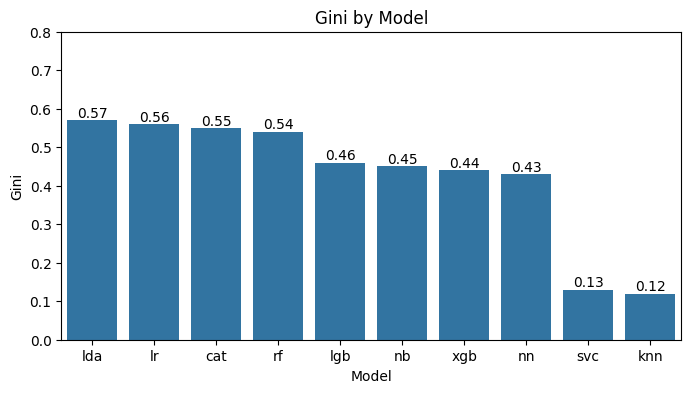

In [122]:
# Join all predictions
pred=pd.concat([pred_xgb, 
                pred_lgb, 
                pred_cat, 
                pred_rfc, 
                pred_lrg, 
                pred_nb, 
                pred_knn, 
                pred_svc, 
                pred_mlp, 
                pred_lda], axis=0).reset_index(drop=True)

# Gini
gini_df=gini_group(y_true=pred['target'], 
                   y_score=pred['pred'], 
                   group=pred['model'], 
                   round=2)\
                  .sort_values('Gini', ascending=False)\
                  .reset_index()

# ROC Curve
plt.figure(figsize=(8, 4))
ax=sns.barplot(data=gini_df, y='Gini', x='group')
ax.bar_label(ax.containers[0])
plt.ylabel('Gini')
plt.xlabel('Model')
plt.ylim(0, 0.8)
plt.title('Gini by Model')
plt.show()

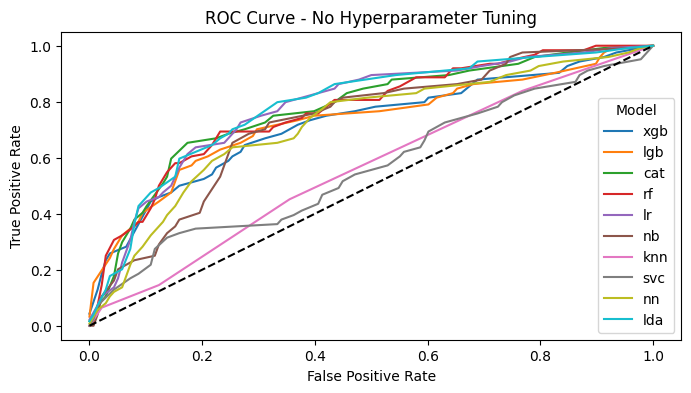

In [123]:
# ROC Curve
roc_curve_df=roc_curve_group(y_true=pred['target'], 
                             y_score=pred['pred'], 
                             group=pred['model'], 
                             round=6)

# Plot ROC Curve
plt.figure(figsize=(8, 4))
sns.lineplot(data=roc_curve_df, x='fpr', y='tpr', hue='Model', errorbar=None)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - No Hyperparameter Tuning')
plt.show()